# Low-Pass Filtering IMU Sample Data
This notebook loads the synthetic Sensor data from the Seeed Studio XIAO nRF52840 Sense Plus, applies a simple first-order low-pass filter to the motion signals, and visualizes the noise reduction.

## Imports and Configuration
We'll use pandas/numpy for data wrangling and Matplotlib for visualization.

In [13]:
from fitness_ai import processed_data_path, raw_data_path

RAW_DATA_PATH = raw_data_path('deep-squat/athlete_04_deep-squat_2025-11-25T07-15-45_21.csv')
OUTPUT_PATH = processed_data_path('deep-squat/athlete_04_deep-squat_2025-11-25T07-15-45_21.csv')

OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)

print(f'Raw data: {RAW_DATA_PATH}')
print(f'Filtered output will be written to: {OUTPUT_PATH}')


Raw data: /Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/raw/deep-squat/athlete_04_deep-squat_2025-11-25T07-15-45_21.csv
Filtered output will be written to: /Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/filtered/deep-squat/athlete_04_deep-squat_2025-11-25T07-15-45_21.csv


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')


## Load the IMU Sample
The CSV stores 10 seconds of data sampled at 50 Hz.

In [15]:
FS = 104.0  # sampling frequency in Hz for the wrist IMU


df = pd.read_csv(RAW_DATA_PATH)
df.head()


,Timestamp,Acceleration_X,Acceleration_Y,Acceleration_Z,Gyro_X,Gyro_Y,Gyro_Z
0,2025-11-25T07:15:45,-0.12805,-0.00622,-9.84302,-0.18028,-0.05398,-0.09843
1,2025-11-25T07:15:45.009615,-0.11101,0.10475,-9.92460,-0.12504,0.04872,-0.09120
2,2025-11-25T07:15:45.019231,-0.16154,0.10286,-9.96580,-0.10065,-0.01143,-0.02538
3,2025-11-25T07:15:45.028846,-0.10715,0.08608,-9.96264,-0.07988,0.02675,-0.05197
4,2025-11-25T07:15:45.038462,-0.12620,0.02102,-9.92691,-0.09304,0.02662,-0.07090


## Define a Low-Pass Filter
We implement a first-order infinite impulse response (IIR) low-pass filter based on an RC network. It attenuates frequencies above the chosen cutoff while preserving lower-frequency motion.

In [16]:
from scipy import signal
from datetime import datetime


ORDER = 4
CUTOFF_HZ = 3.0  # adjust based on how aggressive you want the smoothing
columns_to_filter = [
    'Acceleration_X', 'Acceleration_Y', 'Acceleration_Z',
    'Gyro_X', 'Gyro_Y', 'Gyro_Z'
]

b, a = signal.butter(ORDER, CUTOFF_HZ, btype='low', fs=FS)

filtered_df = df.copy()
for column in columns_to_filter:
    filtered_df[column] = signal.filtfilt(b, a, df[column])

# 方法：基于时间戳（更精确）
# 将字符串时间戳转换为 datetime 对象，容忍小数秒位数不固定（例如 .25 或 .009615）
ts_series = df['Timestamp'].astype(str).str.replace('Z', '', regex=False).str.strip()

def normalize_iso(ts_str: str) -> str:
    if '.' in ts_str:
        date_part, frac = ts_str.split('.', 1)
        frac = (frac + '000000')[:6]  # pad/truncate to microseconds
        return f"{date_part}.{frac}"
    return ts_str

def robust_parse(ts_str: str) -> datetime:
    normalized = normalize_iso(ts_str)
    try:
        return datetime.strptime(normalized, "%Y-%m-%dT%H:%M:%S.%f")
    except ValueError:
        try:
            return datetime.strptime(normalized, "%Y-%m-%dT%H:%M:%S")
        except ValueError as exc:
            raise ValueError(f"Cannot parse timestamp: {ts_str}") from exc

df['Timestamp_dt'] = ts_series.apply(robust_parse)

# 计算相对于第一帧的时间（秒）
time_s = (df['Timestamp_dt'] - df['Timestamp_dt'].iloc[0]).dt.total_seconds()
filtered_df["time_s"] = time_s


## Compare Raw vs Filtered Signals
We'll plot accelerometer and gyroscope data to see the smoothing effect of the filter.

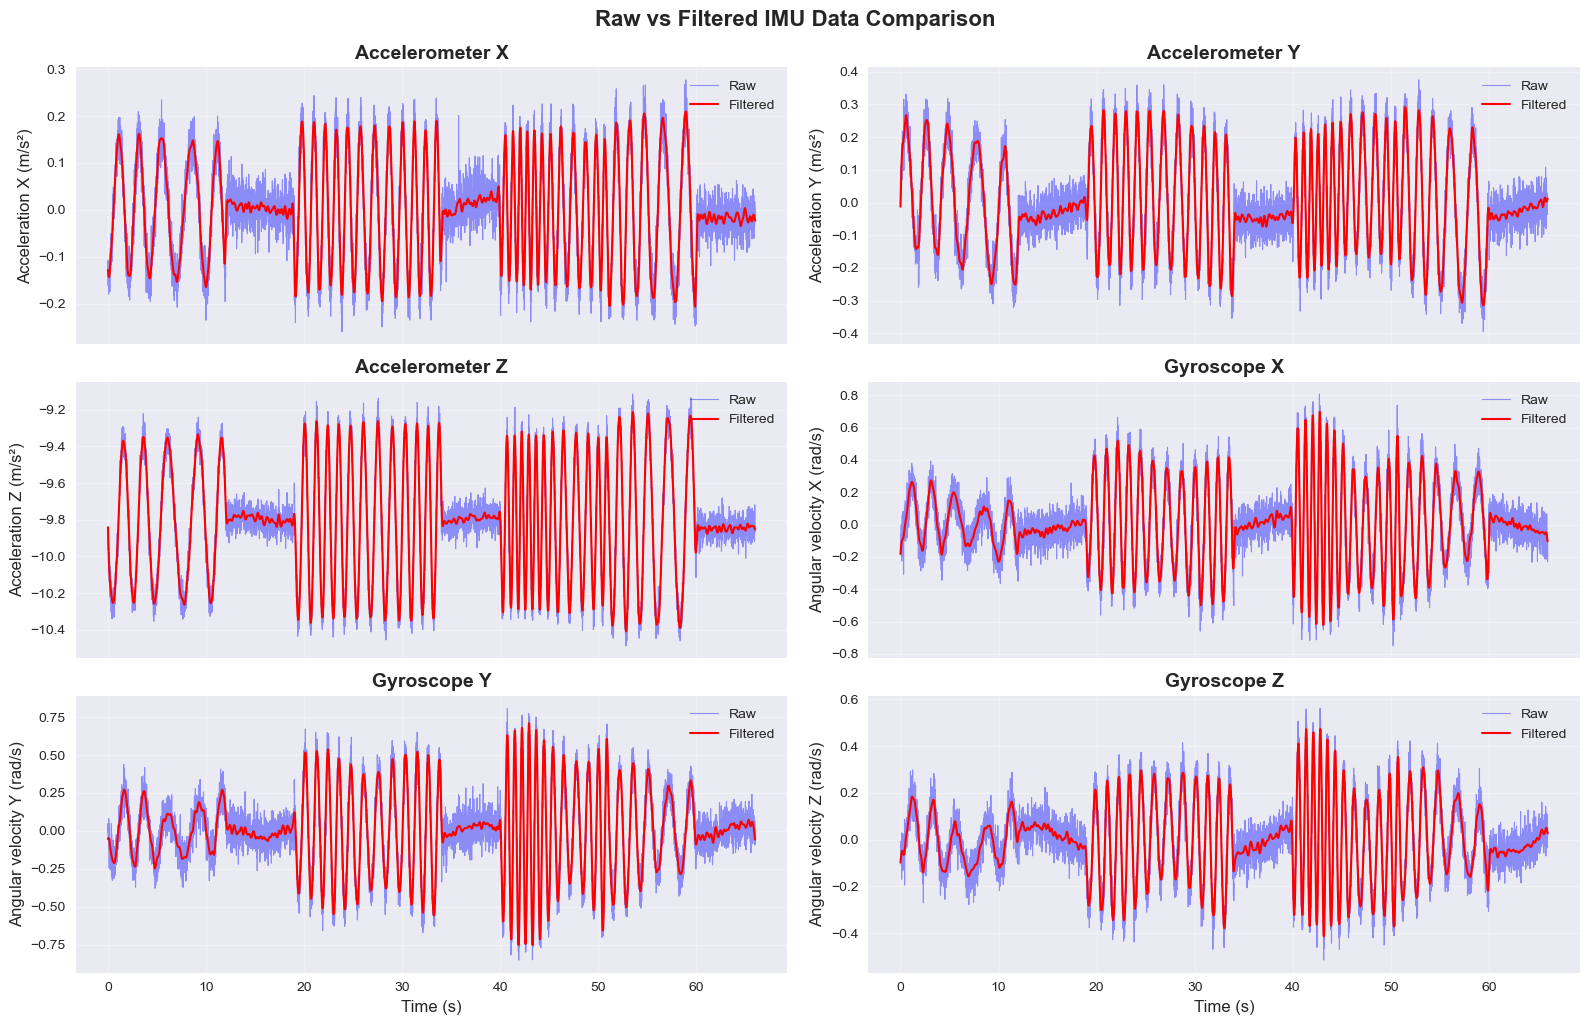

In [17]:

# 定义子图配置 - 根据您的列名和单位进行调整
axis_configs = [
    ('Acceleration_X', 'Acceleration X (m/s²)', 'Accelerometepr X'),
    ('Acceleration_Y', 'Acceleration Y (m/s²)', 'Accelerometer Y'),
    ('Acceleration_Z', 'Acceleration Z (m/s²)', 'Accelerometer Z'),
    ('Gyro_X', 'Angular velocity X (rad/s)', 'Gyroscope X'),
    ('Gyro_Y', 'Angular velocity Y (rad/s)', 'Gyroscope Y'),
    ('Gyro_Z', 'Angular velocity Z (rad/s)', 'Gyroscope Z'),
]

# 创建3行2列的子图
fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharex=True)
axes = axes.flatten()  # 将2D轴数组展平为1D便于循环

# 绘制每个传感器的原始数据 vs 滤波数据对比
for ax, (column, ylabel, title) in zip(axes, axis_configs):
    # 绘制原始数据（半透明，便于观察滤波效果）
    ax.plot(time_s, df[column], label='Raw', alpha=0.4, color='blue', linewidth=0.8)
    # 绘制滤波后的数据（更清晰）
    ax.plot(time_s, filtered_df[column], label='Filtered', linewidth=1.5, color='red')

    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)  # 添加网格线便于观察

# 仅为底部两个子图添加X轴标签
for ax in axes[-2:]:
    ax.set_xlabel('Time (s)', fontsize=12)

# 自动调整子图间距
fig.tight_layout()
plt.suptitle('Raw vs Filtered IMU Data Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.show()

## Save Filtered Output (Optional)
You can persist the filtered signals for downstream processing.

In [18]:
filtered_df.to_csv(OUTPUT_PATH, index=False)
OUTPUT_PATH


PosixPath('/Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/filtered/deep-squat/athlete_04_deep-squat_2025-11-25T07-15-45_21.csv')